# Intelligent Document Processing OCR BOT:

Intelligent Document Processing (IDP) is an advanced automation technology that transforms the way businesses handle documents. By leveraging artificial intelligence (AI), IDP systems can automatically read, understand, and process vast quantities of documents, extracting crucial data and feeding it into various business workflows. This technology is a significant leap from traditional Optical Character Recognition (OCR) as it not only digitizes text but also comprehends the context and structure of the information within documents.

At its core, IDP is designed to tackle the challenge of processing unstructured and semi-structured data, which make up a large portion of business documents such as invoices, contracts, emails, and forms. By automating the extraction and interpretation of this data, IDP significantly reduces the need for manual data entry, leading to increased efficiency, higher accuracy, and substantial cost savings.

---

### The Inner Workings of Intelligent Document Processing

The power of IDP lies in its sophisticated multi-step process that intelligently handles documents from ingestion to data delivery. This process typically involves several key stages:

**1. Document Ingestion:** The first step involves importing documents from various sources and in multiple formats, including scanned paper documents, PDFs, Word files, and images.

**2. Pre-processing:** To enhance the quality of the input, documents undergo a pre-processing stage. This includes techniques like noise reduction, image enhancement, and deskewing to improve the accuracy of subsequent data extraction.

**3. Document Classification:** Using machine learning algorithms, the IDP system automatically categorizes documents based on their layout and content. This allows the system to differentiate between an invoice, a purchase order, or a legal contract, for instance.

**4. Data Extraction:** This is the core function of IDP. Advanced AI technologies, including Natural Language Processing (NLP) and computer vision, are employed to identify and extract relevant data fields. For example, from an invoice, it can pull out the invoice number, date, vendor name, and line-item details.

**5. Data Validation:** The extracted data is then validated against predefined rules and existing databases to ensure accuracy and consistency. Any exceptions or discrepancies can be flagged for human review in a "human-in-the-loop" process, which also helps to train and improve the AI model over time.

**6. Integration:** Finally, the structured and validated data is seamlessly integrated into downstream business systems such as Enterprise Resource Planning (ERP), Customer Relationship Management (CRM), or other databases, making the information readily available for further processing and analysis.


From **finance departments** automating invoice processing and expense management to **healthcare organizations** streamlining patient record management and claims processing, IDP is proving to be a game-changer. Even  **human resources** can expedite resume screening and employee onboarding. As the technology continues to evolve, its applications are expected to expand even further, solidifying its role as a cornerstone of modern digital transformation.

# Our Approach

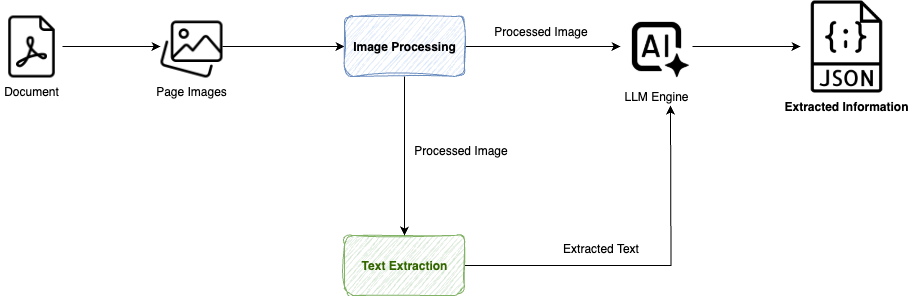

# SROIEv2: The Receipts Dataset

In [2]:
!pip install pdf2image
!pip install pytesseract pillow

## Getting the data

In [3]:
import os
import cv2
import json
import time
import shutil
import kagglehub
import subprocess
import pytesseract
import numpy as np
from PIL import Image
from google import genai
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from google.colab import userdata
from collections import defaultdict
from collections import defaultdict
from pdf2image import convert_from_path

In [4]:
# Download latest version of Resume Dataset
path = kagglehub.dataset_download("snehaanbhawal/resume-dataset")

print("Path to resume dataset files:", path)

Using Colab cache for faster access to the 'resume-dataset' dataset.
Path to resume dataset files: /kaggle/input/resume-dataset


In [5]:
base_path = Path("/kaggle/input/resume-dataset")

# Overall counts
total_files = 0
ext_counts = defaultdict(int)
folder_counts = defaultdict(int)

for root, dirs, files in os.walk(base_path):
    folder = Path(root).relative_to(base_path)
    folder_counts[str(folder)] += len(files)
    total_files += len(files)
    for f in files:
        ext_counts[Path(f).suffix.lower()] += 1

print("📊 Dataset Summary")
print(f"Total files: {total_files}")
print("\nBy extension:")
for ext, cnt in ext_counts.items():
    print(f"  {ext or '[no extension]'}: {cnt}")

print("\nBy folder:")
for folder, cnt in folder_counts.items():
    print(f"  {folder}: {cnt} files")

📊 Dataset Summary
Total files: 2485

By extension:
  .csv: 1
  .pdf: 2484

By folder:
  .: 0 files
  Resume: 1 files
  data: 0 files
  data/data: 0 files
  data/data/DESIGNER: 107 files
  data/data/BPO: 22 files
  data/data/FINANCE: 118 files
  data/data/CONSTRUCTION: 112 files
  data/data/SALES: 116 files
  data/data/AUTOMOBILE: 36 files
  data/data/CONSULTANT: 115 files
  data/data/CHEF: 118 files
  data/data/APPAREL: 97 files
  data/data/AGRICULTURE: 63 files
  data/data/TEACHER: 102 files
  data/data/HR: 110 files
  data/data/DIGITAL-MEDIA: 96 files
  data/data/ACCOUNTANT: 118 files
  data/data/HEALTHCARE: 115 files
  data/data/INFORMATION-TECHNOLOGY: 120 files
  data/data/ADVOCATE: 118 files
  data/data/FITNESS: 117 files
  data/data/AVIATION: 117 files
  data/data/PUBLIC-RELATIONS: 111 files
  data/data/ENGINEERING: 118 files
  data/data/BUSINESS-DEVELOPMENT: 120 files
  data/data/BANKING: 115 files
  data/data/ARTS: 103 files


## Ingestion and PDF-to-Image Conversion

The ingestion step is responsible for:

1. Collecting all resume PDFs from the dataset, including nested category folders.
2. Converting PDFs into **high-resolution images (JPG)** suitable for OCR processing.
3. Preserving the folder structure to maintain category information.

This step is essential because OCR engines (like Tesseract) work best on images, not PDFs, and this ensures the resumes can be processed by the downstream IDP pipeline.

---

### Key Components of the Code

1. **Configuration**

   * `OUT_ROOT`: Destination folder where converted images will be saved (`/content/resume_images`).
   * `CANDIDATE_SRCS`: List of possible source directories containing PDFs (centralized PDFs or Kaggle dataset mount).
   * `DPI`: Resolution of converted images; higher DPI improves OCR accuracy but increases processing time.

2. **Poppler Check**

   * `ensure_poppler()` verifies that `pdftoppm` (part of Poppler utils) is installed, which is required by `pdf2image` to convert PDFs into images.
   * If not found, it attempts to install `poppler-utils` automatically (for Colab/Linux environments).

3. **PDF Discovery**

   * `find_pdf_root(candidates)` scans candidate directories recursively to locate all PDFs.
   * Returns the first directory containing PDFs along with the list of files.

4. **PDF Conversion Loop**

   * Iterates over each PDF file.
   * Determines the **relative path** to maintain the original category folder structure.
   * Converts each PDF into one or more images:

     * **Single-page PDFs:** saved as `filename.jpg`.
     * **Multi-page PDFs:** saved as `filename_page_1.jpg`, `filename_page_2.jpg`, etc.
   * Saves images to `OUT_ROOT`, creating folders if necessary.
   * Any errors during conversion are logged for review.

5. **Summary and Verification**

   * Counts the total number of processed PDFs and generated images.
   * Prints the first few image paths for visual confirmation.

After this step, all resumes are ready as images, enabling **OCR extraction**, **entity recognition**, and further **IDP processing**.

In [6]:
# Ingestion: recursively convert all PDFs -> JPEGs, preserving category subfolders

# Config
OUT_ROOT = Path("/content/resume_images")     # where JPGs will be saved
CANDIDATE_SRCS = [
    Path("/content/resume_pdfs"),            # if you already copied PDFs here
    Path("/kaggle/input/resume-dataset"),    # typical Kaggle mount
]

DPI = 300  # increase for better OCR accuracy (slower)
OUT_ROOT.mkdir(parents=True, exist_ok=True)

# Ensure poppler (pdftoppm) is available for pdf2image
def ensure_poppler():
    if shutil.which("pdftoppm") is None:
        print("poppler-utils not found — attempting to install (Colab/Linux)...")
        try:
            subprocess.run(["apt-get","update","-y"], check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
            subprocess.run(["apt-get","install","-y","poppler-utils"], check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
            if shutil.which("pdftoppm") is None:
                raise RuntimeError("pdftoppm still not found after install.")
            print("poppler-utils installed.")
        except Exception as e:
            print("⚠️ Could not install poppler-utils automatically. Install it manually (e.g. `apt-get install poppler-utils`) and re-run.")
            raise e
    else:
        print("poppler-utils found.")

# Find a source root that actually contains PDFs
def find_pdf_root(candidates):
    for c in candidates:
        if c.exists():
            pdfs = list(c.rglob("*.pdf"))
            if pdfs:
                return c, pdfs
    return None, []

# Main
ensure_poppler()
src_root, pdf_list = find_pdf_root(CANDIDATE_SRCS)
if not src_root:
    raise FileNotFoundError(
        "No PDFs found under candidate locations. Checked: "
        + ", ".join(str(p) for p in CANDIDATE_SRCS)
        + ".\nIf your PDFs are in a different folder, update CANDIDATE_SRCS or set pdf_dir accordingly."
    )

print(f"Found {len(pdf_list)} PDFs under: {src_root}")
processed = 0
errors = []

for pdf_file in tqdm(pdf_list, desc="Converting PDFs"):
    try:
        # create an output directory that mirrors the source subfolder structure
        rel_path = pdf_file.relative_to(src_root)
        out_dir = OUT_ROOT / rel_path.parent
        out_dir.mkdir(parents=True, exist_ok=True)

        pages = convert_from_path(str(pdf_file), dpi=DPI)  # list of PIL.Image
        for i, page in enumerate(pages, start=1):
            if len(pages) == 1:
                out_name = f"{pdf_file.stem}.jpg"
            else:
                out_name = f"{pdf_file.stem}_page_{i}.jpg"
            out_path = out_dir / out_name
            page.save(str(out_path), "JPEG")
        processed += 1
    except Exception as e:
        errors.append((pdf_file, str(e)))

# Summary
total_images = sum(1 for _ in OUT_ROOT.rglob("*.jpg"))
print(f"\nConversion finished. PDFs processed: {processed}; images created: {total_images}; errors: {len(errors)}")
if errors:
    print("Sample errors (first 5):")
    for p, err in errors[:5]:
        print(f" - {p}: {err}")

# Optional: print a small sample of saved images
sample_images = list(OUT_ROOT.rglob("*.jpg"))[:5]
print("\nSaved image samples:")
for s in sample_images:
    print(" -", s)

poppler-utils not found — attempting to install (Colab/Linux)...
poppler-utils installed.
Found 2484 PDFs under: /kaggle/input/resume-dataset


Converting PDFs:   0%|          | 0/2484 [00:00<?, ?it/s]


Conversion finished. PDFs processed: 2484; images created: 4881; errors: 0

Saved image samples:
 - /content/resume_images/data/data/DESIGNER/29865476_page_2.jpg
 - /content/resume_images/data/data/DESIGNER/38744475_page_1.jpg
 - /content/resume_images/data/data/DESIGNER/35990852_page_1.jpg
 - /content/resume_images/data/data/DESIGNER/10751444_page_1.jpg
 - /content/resume_images/data/data/DESIGNER/15471999_page_2.jpg


## Understanding the Data

The downloaded dataset contains the following structure:

1. **Resume.csv**

   * A CSV file containing metadata and possibly labels for the resumes.
   * This file can be used to map resumes to their categories (e.g., job roles such as IT, Finance, Healthcare).

2. **data/data/**

   * This is the main folder containing all resume files in **PDF format**.

   * Each subfolder inside `data/data/` represents a **career domain/category**, such as:

     * `INFORMATION-TECHNOLOGY`
     * `HEALTHCARE`
     * `FINANCE`
     * `ENGINEERING`
     * `HR`
     * … and many more.

   * Each subfolder contains multiple PDF resumes belonging to that category.

   * Example structure:

     ```
     data/data/INFORMATION-TECHNOLOGY/resume1.pdf
     data/data/INFORMATION-TECHNOLOGY/resume2.pdf
     data/data/HEALTHCARE/resume1.pdf
     data/data/FINANCE/resume1.pdf
     ```

3. **Preprocessing requirement**

   * Since resumes are provided as PDFs, they need to be converted into **images (JPG)** before applying OCR/IDP techniques.
   * Each PDF is assumed to be a single-page resume (though multi-page handling is also supported).
   * After conversion, OCR tools can be used to extract unstructured text from resumes.

4. **Ground truth labels**

   * Unlike the receipt dataset which had bounding boxes and entity annotations, this dataset provides **category labels** (job domains) instead of structured annotations.
   * Our pipeline will therefore focus on **information extraction from OCR text** (e.g., Name, Email, Phone, Skills, Education, Experience) and **classification into job categories**.

## Image Preprocesing: OpenCV

In [7]:
one_image_path = "/content/resume_images/data/data/ENGINEERING/15601399.jpg"

In [8]:
def display_image(image, title="Image"):
    plt.figure(figsize=(7, 7))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

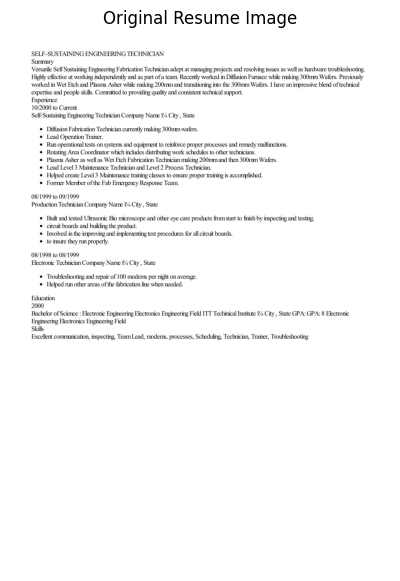

In [9]:
one_image = cv2.imread(one_image_path)
display_image(one_image, "Original Resume Image")

### Grayscale Conversion

**Why?** Color information is usually not necessary for reading the text on a receipt. Converting the image to grayscale simplifies it from three color channels (Red, Green, Blue) to a single channel (intensity/brightness). This reduces computational complexity and is a required first step for many subsequent operations like thresholding.

In [10]:
# Convert the image to grayscale
def convert_to_grayscale(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

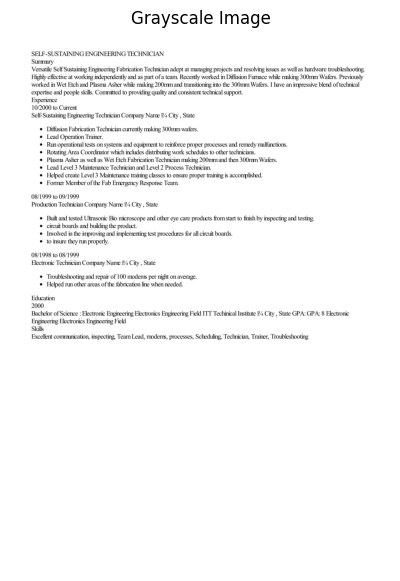

In [11]:
grayscale_image = convert_to_grayscale(one_image)
display_image(grayscale_image, "Grayscale Image")

### Noise (blur) Reduction
**Why?** Scanned images or photos often contain "noise" (random variations in brightness or color). This can look like small specks or graininess, which can confuse OCR algorithms. Applying a slight blur helps to smooth out this noise. A **Gaussian blur** is a common choice as it effectively averages out pixel values with a weighted average, preserving edges better than a simple blur.

In [12]:
def reduce_noise(gray_image):
  return cv2.GaussianBlur(gray_image, (5, 5), 0)

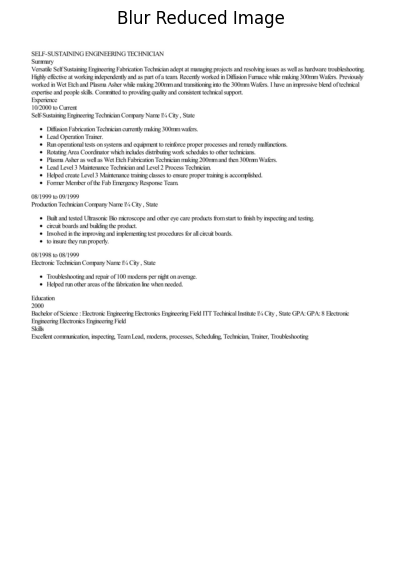

In [13]:
blur_reduced_image = reduce_noise(grayscale_image)
display_image(blur_reduced_image, "Blur Reduced Image")

### Binarization (Thresholding)

**Why?** This is one of the most critical steps. Binarization converts the grayscale image into a pure black-and-white image. The goal is to make the text **black** and the background **white**. However, receipts often have uneven lighting or shadows, so a simple (global) threshold won't work well. We use **adaptive thresholding**, which calculates a different threshold for smaller regions of the image, making it robust to lighting changes.

`cv2.adaptiveThreshold()`:

  * `cv2.ADAPTIVE_THRESH_GAUSSIAN_C`: Calculates the threshold for a pixel based on a weighted sum of neighborhood values.
  * `cv2.THRESH_BINARY_INV`: Inverts the result. We want the text to be white pixels (value 255) and the background black (value 0) for the next step (skew correction), which often works by finding white pixel contours.
  * `11`: The size of the neighborhood area (block size).
  * `4`: A constant subtracted from the mean. It's a fine-tuning parameter.

In [14]:
def binarize_image(blur_reduced_image):
  return cv2.adaptiveThreshold(
    blur_reduced_image,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, # Invert the colors (text becomes white)
    11, # Block size
    4  # Constant C
  )

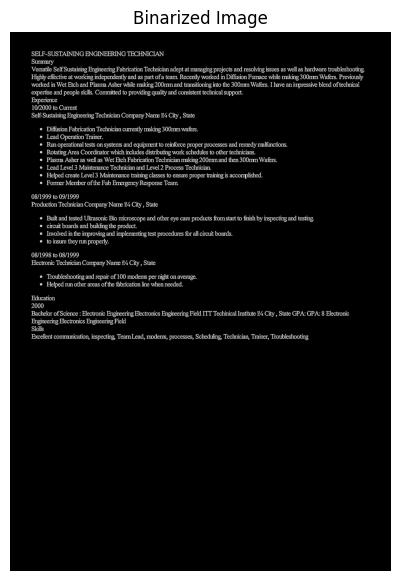

In [15]:
binarized_image = binarize_image(blur_reduced_image)
display_image(binarized_image, "Binarized Image")

### Skew Correction

**Why?** Receipts are often scanned or photographed at a slight angle. This skew can significantly reduce the accuracy of OCR. We need to detect this angle and rotate the image to make the text perfectly horizontal.

A common technique is to find the angle of the minimum-area bounding box that encloses all the text (the white pixels in our binarized image) and then rotate the original image by that angle.

In [16]:
def deskew_image(image):
    """
    Corrects the skew of an image by finding the minimum area rectangle
    of the text block and rotating accordingly.
    """
    # Find all non-zero (white) pixels
    coords = cv2.findNonZero(image)

    # Get the minimum area bounding rectangle
    # It returns (center(x,y), (width, height), angle of rotation)
    rect = cv2.minAreaRect(coords)
    angle = rect[-1] - 90

    # The `cv2.minAreaRect` angle has a specific range.
    # We need to adjust it for our rotation.
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = angle

    # Get the rotation matrix and rotate the image
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
                             flags=cv2.INTER_CUBIC,
                             borderMode=cv2.BORDER_REPLICATE)
    print(f"Detected skew angle: {angle:.2f} degrees")

    # Now, rotate the original grayscale image by the same angle
    (h, w) = rotated.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    deskewed_gray = cv2.warpAffine(rotated, M, (w, h),
                                  flags=cv2.INTER_CUBIC,
                                  borderMode=cv2.BORDER_REPLICATE)

    return deskewed_gray

In [17]:
deskewed_image = deskew_image(binarized_image)

Detected skew angle: 0.00 degrees


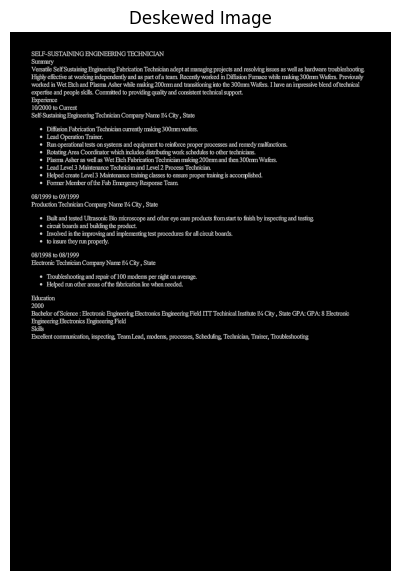

In [18]:
display_image(deskewed_image, "Deskewed Image")

Let's run the above code for all images

In [19]:
def process_one_image(image):
  image = convert_to_grayscale(image)
  print("Converted image to grayscale..")
  image = reduce_noise(image)
  print("Reduced noise in the image..")
  image = binarize_image(image)
  print("Binarized the image..")
  image = deskew_image(image)
  print("Corrected image orientation..")
  return image

In [23]:
# Input folder containing resume images
input_folder = Path("/content/resume_images/data/data/ENGINEERING")
# Output folder for processed images
output_folder = Path("/content/processed_images")
output_folder.mkdir(parents=True, exist_ok=True)

# Function process_one_image should already be defined
# Example: processed_image = process_one_image(image)

# --- Group images by PDF stem (to handle multi-page resumes) ---
images_by_pdf = defaultdict(list)
for img_path in sorted(input_folder.rglob("*.jpg")):  # sorted ensures consistent order
    # Identify PDF stem (remove "_page_X" if present)
    stem = "_".join(img_path.stem.split("_")[:-2]) if "_page_" in img_path.stem else img_path.stem
    images_by_pdf[stem].append(img_path)

# Process first 4 PDFs (all pages)
pdf_stems = sorted(images_by_pdf.keys())[:5]

start_time = time.time()

for stem in pdf_stems:
    for image_path in sorted(images_by_pdf[stem]):  # sort pages within each PDF
        image_name = image_path.name
        print(f"Processing image: {image_name}")

        # Read image
        image = cv2.imread(str(image_path))

        # Apply your processing function
        processed_image = process_one_image(image)

        # Save processed image
        output_path = output_folder / image_name
        cv2.imwrite(str(output_path), processed_image)

        print(f"Saved processed image to: {output_path}")
        print("-"*50)

print("Processing images is completed.")
print(f"Total time taken: {time.time() - start_time:.2f} seconds")

Processing image: 10030015.jpg
Converted image to grayscale..
Reduced noise in the image..
Binarized the image..
Detected skew angle: 0.00 degrees
Corrected image orientation..
Saved processed image to: /content/processed_images/10030015.jpg
--------------------------------------------------
Processing image: 10219099_page_1.jpg
Converted image to grayscale..
Reduced noise in the image..
Binarized the image..
Detected skew angle: 0.00 degrees
Corrected image orientation..
Saved processed image to: /content/processed_images/10219099_page_1.jpg
--------------------------------------------------
Processing image: 10219099_page_2.jpg
Converted image to grayscale..
Reduced noise in the image..
Binarized the image..
Detected skew angle: -0.00 degrees
Corrected image orientation..
Saved processed image to: /content/processed_images/10219099_page_2.jpg
--------------------------------------------------
Processing image: 10624813_page_1.jpg
Converted image to grayscale..
Reduced noise in the im

## Text Extraction: Tesseract

Tesseract OCR is a powerful and widely-used open-source optical character recognition (OCR) engine. In simple terms, it's a software that can "read" text from images and convert it into machine-readable text. This means you can take a picture of a document, a sign, or any other object containing text, and Tesseract can extract that text so you can edit, search, or analyze it.

### A Brief History and Development

Originally developed by Hewlett-Packard in the 1980s, Tesseract was later open-sourced in 2005 and has been sponsored by Google since 2006. This has led to significant improvements and made it one of the most accurate and versatile free OCR engines available. The latest versions of Tesseract utilize long short-term memory (LSTM), a type of recurrent neural network (RNN), which has greatly enhanced its ability to recognize text with high accuracy.



### Core Functionalities and Capabilities

Tesseract boasts a rich set of features that make it a flexible tool for various applications:

  * **Extensive Language Support:** Tesseract can recognize over 100 languages, making it a truly global OCR solution. It also supports multiple scripts and can even be trained to recognize new languages.
  * **Multiple Output Formats:** It can output the recognized text in various formats, including plain text, HTML, PDF, and TSV (tab-separated values). This allows for easy integration with other software and workflows.
  * **Page Segmentation Modes:** Tesseract offers different page segmentation modes, which help in correctly identifying the layout of a document, including columns, paragraphs, and blocks of text.
  * **Character Recognition and Confidence:** Not only does it recognize characters, but it can also provide a confidence score for each recognized character, word, or line. This is useful for assessing the accuracy of the OCR process.
  * **Command-Line and API Access:** Tesseract can be used as a command-line tool for quick and simple OCR tasks. For more complex integrations, it provides an API that allows developers to incorporate its OCR capabilities into their own applications. Popular wrappers like Pytesseract make it easy to use Tesseract with programming languages like Python.


### Installation
`pip install pytesseract pillow`


### How to Use Tesseract

For developers, integrating Tesseract into an application is straightforward using its API. Here is a simple example using the `pytesseract` wrapper in Python:

```python

from PIL import Image
import pytesseract


text = pytesseract.image_to_string(Image.open(filename))

print(text)
```



### Common Use Cases and Applications

The ability to extract text from images opens up a vast range of applications across various industries:

  * **Document Digitization:** Converting scanned documents, books, and historical archives into searchable digital text.
  * **Data Entry Automation:** Automating the process of entering data from invoices, receipts, and forms.
  * **Accessibility:** Assisting visually impaired individuals by converting printed text into speech.
  * **License Plate Recognition:** In law enforcement and traffic management systems.
  * **Social Media Monitoring:** Analyzing text within images shared on social media platforms.
  * **Translation:** Extracting text from an image and then using a translation service to translate it.

While Tesseract is a powerful tool, the accuracy of its output heavily depends on the quality of the input image. For best results, images should be clear, well-lit, and have a high resolution. Pre-processing steps like resizing, noise reduction, and converting to grayscale can significantly improve OCR accuracy.

In [24]:
# Folder containing processed images
processed_folder = "/content/processed_images"

# List of images to process
images_to_ocr = [
    "10030015.jpg",
    "10219099_page_1.jpg",
    "10219099_page_2.jpg",
    "10624813_page_1.jpg",
    "10624813_page_2.jpg",
    "10712803_page_1.jpg",
    "10712803_page_2.jpg",
    "10985403_page_1.jpg",
    "10985403_page_2.jpg"
]

# Run OCR and print text for each image
for img_name in images_to_ocr:
    img_path = f"{processed_folder}/{img_name}"
    text = pytesseract.image_to_string(Image.open(img_path))
    print(f"--- OCR Output for {img_name} ---")

--- OCR Output for 10030015.jpg ---
--- OCR Output for 10219099_page_1.jpg ---
--- OCR Output for 10219099_page_2.jpg ---
--- OCR Output for 10624813_page_1.jpg ---
--- OCR Output for 10624813_page_2.jpg ---
--- OCR Output for 10712803_page_1.jpg ---
--- OCR Output for 10712803_page_2.jpg ---
--- OCR Output for 10985403_page_1.jpg ---
--- OCR Output for 10985403_page_2.jpg ---


In [25]:
# Input folder containing processed images
input_folder_path = "/content/processed_images"
# Output folder for extracted text
output_folder_path = "/content/tesseract_output"
os.makedirs(output_folder_path, exist_ok=True)
print(f"Output folder: {output_folder_path}")

# List all images in input folder
image_files = [f for f in os.listdir(input_folder_path) if f.lower().endswith(".jpg")]
total_images = len(image_files)
print(f"Total images found: {total_images}")

start_time = time.time()

# Loop through all images
for i, image_name in enumerate(image_files, 1):
    print(f"Processing image {i}/{total_images}: {image_name}")

    image_path = os.path.join(input_folder_path, image_name)
    print("Extracting text from image...")

    # OCR extraction
    text = pytesseract.image_to_string(Image.open(image_path))

    # Save text to new folder
    output_path = os.path.join(output_folder_path, image_name.replace(".jpg", ".txt"))
    with open(output_path, "w", encoding="utf-8") as f:
        f.write(text)

    print(f"Saved extracted text to: {output_path}")
    print("-"*50)

print("Text extraction completed.")
print(f"Total time taken: {time.time() - start_time:.2f} seconds")

Output folder: /content/tesseract_output
Total images found: 9
Processing image 1/9: 10985403_page_2.jpg
Extracting text from image...
Saved extracted text to: /content/tesseract_output/10985403_page_2.txt
--------------------------------------------------
Processing image 2/9: 10030015.jpg
Extracting text from image...
Saved extracted text to: /content/tesseract_output/10030015.txt
--------------------------------------------------
Processing image 3/9: 10985403_page_1.jpg
Extracting text from image...
Saved extracted text to: /content/tesseract_output/10985403_page_1.txt
--------------------------------------------------
Processing image 4/9: 10219099_page_1.jpg
Extracting text from image...
Saved extracted text to: /content/tesseract_output/10219099_page_1.txt
--------------------------------------------------
Processing image 5/9: 10624813_page_1.jpg
Extracting text from image...
Saved extracted text to: /content/tesseract_output/10624813_page_1.txt
--------------------------------

## Information Extraction

In [26]:
prompt = """
Extract the information from the given resume image.
Information to be extracted: name, email, phone, skills.
The image has been converted to grayscale, noise reduced, binarized, and deskewed using OpenCV.
Always give your response in the following format:
{
    "Designation": "DESIGNATION_NAME",
    "Experience": "YEARS_OF_EXPERIENCE",
    "City": "JOB_LOCATION",
    "Skills": "KEY_SKILLS",
}
Also, the text has been extracted from the image using Tesseract.
Use the extracted text as support for extracting information.
If you believe the extraction is incorrect somewhere, you may correct it yourself and provide corrected information.
Respond with the extracted information only in the specified format.
Here is the text:

"""


Can we improve the prompt using the [Unified Framework For An Effective Prompt](https://www.geeksforgeeks.org/data-science/a-unified-framework-for-an-effective-prompt/)?

In [27]:
genai_client = genai.Client(api_key=userdata.get('GOOGLE_API_KEY'))

In [28]:
# Folder paths
image_folder_path = "/content/processed_images"
text_folder_path = "/content/tesseract_output"
output_folder_path = "/content/json_output"

# Create output folder if it doesn't exist
os.makedirs(output_folder_path, exist_ok=True)
print(f"Created folder: {output_folder_path}")

# List all images in input folder
image_files = [f for f in os.listdir(image_folder_path) if f.lower().endswith(".jpg")]
total_images = len(image_files)
print(f"Total images in folder: {total_images}")

start_time = time.time()

# Process images
for i, image_name in enumerate(image_files[:20], 1):  # adjust range as needed
    print(f"Processing image {i}/{total_images}: {image_name}")

    # Load image
    image_path = os.path.join(image_folder_path, image_name)
    print(f"Loading image: {image_path}")
    image = Image.open(image_path)

    # Load extracted text
    text_path = os.path.join(text_folder_path, image_name.replace(".jpg", ".txt"))
    print(f"Loading extracted text: {text_path}")
    with open(text_path, "r", encoding="utf-8") as f:
        text = f.read()

    print("Extracting information from image and text...")

    # Use a fresh prompt for each image
    current_prompt = prompt + text

    # Prepare content for GenAI model
    contents = [
        image,
        {"text": current_prompt}
    ]
    response = genai_client.models.generate_content(model='gemini-1.5-flash', contents=contents)

    # Token usage info
    usage_metadata = response.usage_metadata
    print(f"Input Token Count: {usage_metadata.prompt_token_count}")
    print(f"Thoughts Token Count: {usage_metadata.thoughts_token_count}")
    print(f"Output Token Count: {usage_metadata.candidates_token_count}")
    print(f"Total Token Count: {usage_metadata.total_token_count}")

    # Parse JSON safely
    extracted_information = json.loads(response.text.replace('```json', '').replace('```', '').strip())

    # Save JSON output
    output_path = os.path.join(output_folder_path, image_name.replace(".jpg", ".json"))
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(extracted_information, f, indent=4)

    print(f"Saved extracted information to {output_path}")
    print("-"*50)

    time.sleep(60)  # adjust if necessary for rate limits

print("Information Extraction Completed.")
print(f"Total time taken: {time.time() - start_time:.2f} seconds")

Created folder: /content/json_output
Total images in folder: 9
Processing image 1/9: 10985403_page_2.jpg
Loading image: /content/processed_images/10985403_page_2.jpg
Loading extracted text: /content/tesseract_output/10985403_page_2.txt
Extracting information from image and text...
Input Token Count: 458
Thoughts Token Count: None
Output Token Count: 60
Total Token Count: 518
Saved extracted information to /content/json_output/10985403_page_2.json
--------------------------------------------------
Processing image 2/9: 10030015.jpg
Loading image: /content/processed_images/10030015.jpg
Loading extracted text: /content/tesseract_output/10030015.txt
Extracting information from image and text...
Input Token Count: 1005
Thoughts Token Count: None
Output Token Count: 69
Total Token Count: 1074
Saved extracted information to /content/json_output/10030015.json
--------------------------------------------------
Processing image 3/9: 10985403_page_1.jpg
Loading image: /content/processed_images/10